In [1]:
from glob import glob
from scipy import optimize
from waveform_tools import ScopeWaveform
import math
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib widget

In [2]:
infpns = glob('20220321_data_58V/*.csv')

def trigger_intervals_one_file(infpn):
    wf = ScopeWaveform(infpn)
    print(wf.waveform_peaks(9e-3))
    print(wf.df.head())
    wf.draw_waveform()

[(-3.85918e-05, 0.01680000068137355), (-9.6546e-06, 0.01560000058137355), (2.3e-08, 0.01440000058137355), (2.55286e-05, 0.01560000058137355), (5.1876e-05, 0.009600000381373548), (5.69632e-05, 0.009600000381373548)]
         info_name         value    units     time  waveform_value  \
0    Record Length  5.000000e+05   Points -0.00004         -0.0012   
1  Sample Interval  2.000000e-10        s -0.00004          0.0012   
2    Trigger Point  1.999000e+05  Samples -0.00004         -0.0012   
3     Trigger Time  1.405610e-10        s -0.00004         -0.0012   
4              NaN           NaN      NaN -0.00004          0.0036   

   partial_integral  is_peak  
0     -1.200000e-03    False  
1      2.747097e-12    False  
2     -1.200000e-03    False  
3     -2.400000e-03    False  
4      1.200000e-03    False  
20220321_data_58V/sample6.csv waveform_value


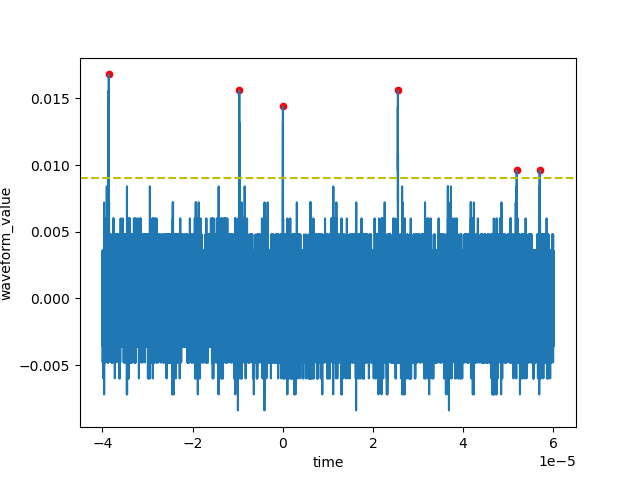

In [3]:
trigger_intervals_one_file(infpns[1])

20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv waveform_value_moving_average_100
20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv waveform_value_moving_average_200
20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv waveform_value


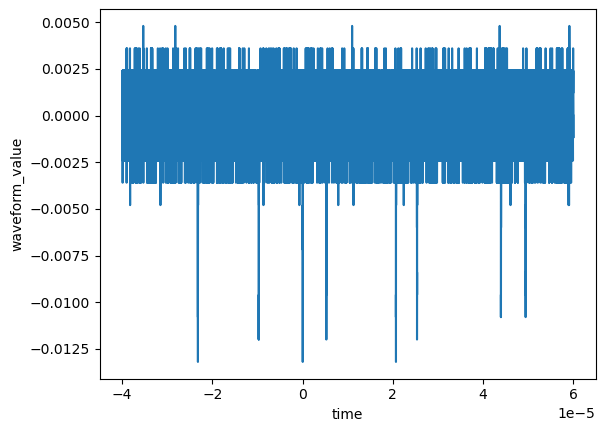

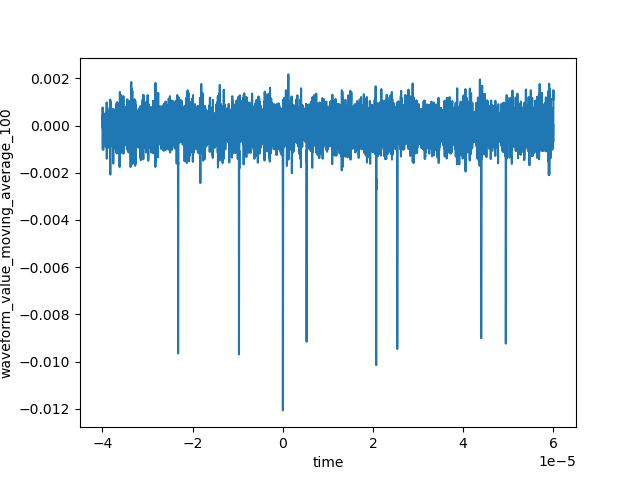

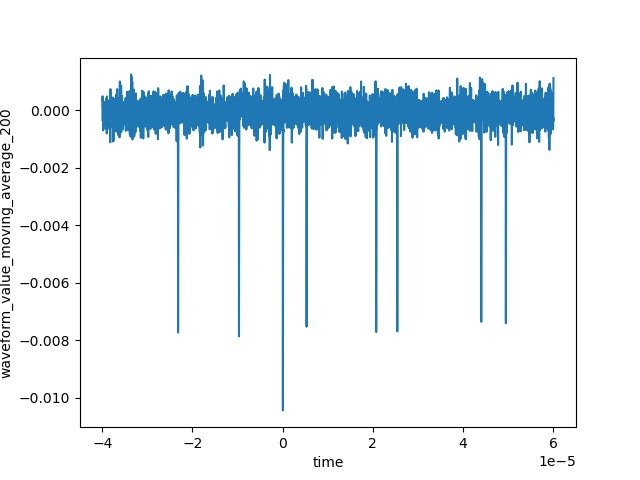

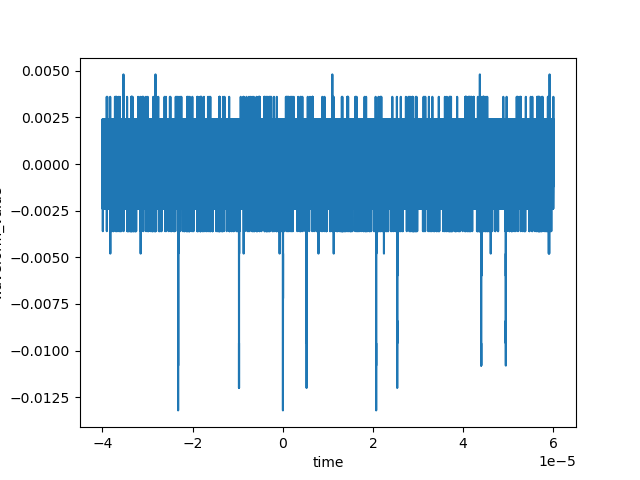

In [4]:
wf = ScopeWaveform('20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv')
wf.add_moving_average(100)
wf.draw_waveform(100)
wf.add_moving_average(200)
wf.draw_waveform(200)
wf.draw_waveform()

20220408_rate_waveform_57.2V_amp_diff_box_25C/sample1.csv waveform_value_moving_average_200
96329.83334938831


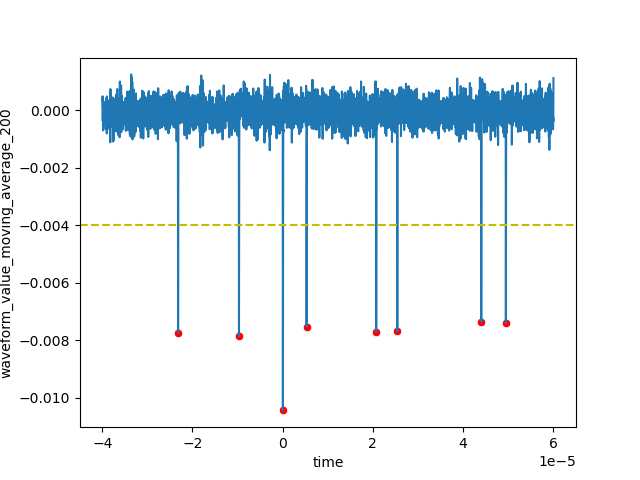

In [5]:
def likelihood_func(b):
    return lambda a: math.pow(a, len(b))*math.exp(-a*sum(b))
wf.waveform_peaks(0.007, polarity=-1)
interarrivals = wf.waveform_peak_time_diffs(0.004, polarity=-1, window_size=200)
wf.draw_waveform(window_size=200)
le = likelihood_func(interarrivals)
r_min = len(interarrivals)/sum(interarrivals)
print(r_min)
# le(r_min)
# t = np.linspace(0, 2*r_min, 100)
# plt.plot(t, le(t), color='red')

64355.79865671285 137463.60896390214


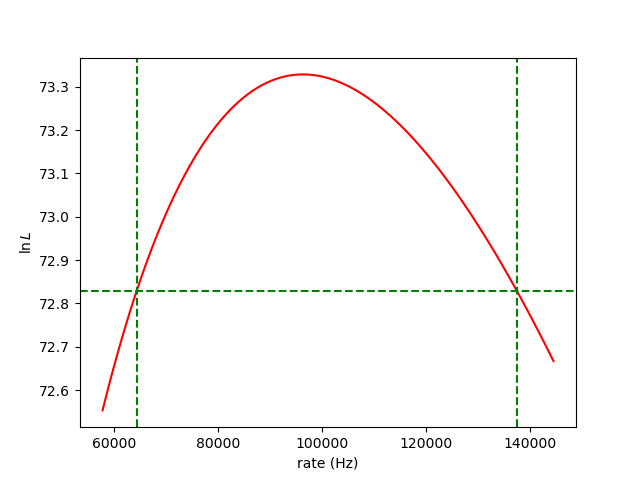

In [6]:
def log_likelihood_func(b):
    return lambda a: len(b)*math.log(a)-a*sum(b)
llf = log_likelihood_func(interarrivals)
llf_vec = np.vectorize(llf)
r_best = len(interarrivals)/sum(interarrivals)

# the 1-sigma boundaries are obtained by the intersection of the llf curve
# with the horizontal line of value llf(best_fit)-0.5
llf_1sigma = llf(r_best)-.5
r_lb = optimize.brentq(lambda x: llf(x)-llf_1sigma, .1*r_best, r_best)
r_ub = optimize.brentq(lambda x: llf(x)-llf_1sigma, r_best, 10*r_best)
print(r_lb, r_ub)

t = np.linspace(.6*r_best, 1.5*r_best, 100)
plt.clf()
plt.plot(t, llf_vec(t), color='red')
plt.axhline(y=llf_1sigma, color='g', linestyle='--')
plt.axvline(x=r_lb, color='g', linestyle='--')
plt.axvline(x=r_ub, color='g', linestyle='--')
plt.ylabel('$\ln L$')
plt.xlabel('rate (Hz)')
plt.show()

In [11]:
class rate_estimate:
    def __init__(self, infpns, polarity, threshold, window_size, name):
        self.infpns = infpns
        self.polarity = polarity
        self.threshold = threshold
        self.window_size = window_size
        self.name = name
        self.wfs = []
        self.interarrivals = []

        # load files into waveforms
        self.load_waveforms()

        # find the MPPC pulses and the interarrival times
        self.find_pulses()
    
    def load_waveforms(self):
        for infpn in self.infpns:
            self.wfs.append(ScopeWaveform(infpn))
    
    def find_pulses(self):
        for wf in self.wfs:
            self.interarrivals.extend(wf.waveform_peak_time_diffs(height_thresh=self.threshold, polarity=self.polarity, window_size=self.window_size))
            wf.draw_waveform(window_size=self.window_size)
    
    def interval_estimation(self):
        def log_likelihood_func(b):
            return lambda a: len(b)*math.log(a)-a*sum(b)
        llf = log_likelihood_func(self.interarrivals)
        llf_vec = np.vectorize(llf)
        r_best = len(self.interarrivals)/sum(self.interarrivals)

        # the 1-sigma boundaries are obtained by the intersection of the llf curve
        # with the horizontal line of value llf(best_fit)-0.5
        llf_1sigma = llf(r_best)-.5
        r_lb = optimize.brentq(lambda x: llf(x)-llf_1sigma, .1*r_best, r_best)
        r_ub = optimize.brentq(lambda x: llf(x)-llf_1sigma, r_best, 10*r_best)

        # make the llf plot
        t = np.linspace(.6*r_best, 1.5*r_best, 100)
        plt.clf()
        plt.plot(t, llf_vec(t), color='red')
        plt.axhline(y=llf_1sigma, color='g', linestyle='--')
        plt.axvline(x=r_lb, color='g', linestyle='--')
        plt.axvline(x=r_ub, color='g', linestyle='--')
        plt.ylabel('$\ln L$')
        plt.xlabel('rate (Hz)')
        plt.title(self.name)
        plt.savefig(f'plots/{os.path.dirname(self.infpns[0])}/log_likelihood_function.png')

        return r_lb, r_best, r_ub

rate_0321 = rate_estimate(glob('20220321_data_58V/*.csv'), polarity=1, threshold=0.004, window_size=200, name='20220321_fastamp_rcfilter_scope_25C_5.8Vover')
rate_0329_diff = rate_estimate(glob('20220329_rate_waveform_57V_amp_diff_box_25C/*.csv'), polarity=-1, threshold=0.004, window_size=200, name='20220329_preamp_different_box_scope_25C_4.8Vover')
rate_0329_same = rate_estimate(glob('20220329_rate_waveform_57V_amp_in_box_25C/*.csv'), polarity=-1, threshold=0.004, window_size=200, name='20220329_preamp_same_box_scope_25C_4.8Vover')
rate_0408 = rate_estimate(glob('20220408_rate_waveform_57.2V_amp_diff_box_25C/*.csv'), polarity=-1, threshold=0.004, window_size=200, name='20220408_preamp_different_box_scope_25C_5.0Vover')

20220321_data_58V/sample3.csv waveform_value_moving_average_200
20220321_data_58V/sample6.csv waveform_value_moving_average_200
20220321_data_58V/sample1.csv waveform_value_moving_average_200
20220321_data_58V/sample7.csv waveform_value_moving_average_200
20220321_data_58V/sample2.csv waveform_value_moving_average_200
20220321_data_58V/sample8.csv waveform_value_moving_average_200
20220321_data_58V/sample5.csv waveform_value_moving_average_200
20220321_data_58V/sample4.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_diff_box_25C/sample3.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_diff_box_25C/sample1.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_diff_box_25C/sample2.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_in_box_25C/sample3.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_in_box_25C/sample1.csv waveform_value_moving_average_200
20220329_rate_waveform_57V_amp_in_box_25C/

In [ ]:
rate_0321.interval_estimation()
rate_0329_diff.interval_estimation()
rate_0329_same.interval_estimation()
rate_0408.interval_estimation()